# Exploratory Data Analysis and Feature Importance

In this notebook, we will:
- evaluate the datatset conditions
- look for relationships in within our data
- apply techniques to discover with features are the most important oens

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')

# base folders
CLEAN_DATA_DIR = Path('../clean_data/')

In [38]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,FAIR Plan Units,% FAIR Plan Units,Total Exposure ($),% Change - Claims (Fire and Smoke),% Change - Earned Premiums,% Change - Expiring Policies,% Change - Losses (Fire and Smoke),% Change - New Policies,% Change - Nonrenewed Policies,% Change - Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
90043,690.0,0.065589,269200641.0,0.323529,0.290331,0.028244,2.630341,-0.040490,0.026915,-0.083004,...,0.876780,1.315171,1.315171,0.876780,3736.399430,0.099663,698.212167,698.212167,5.351381,0.900337
91105,157.0,0.051007,252107854.0,-0.166667,0.321318,0.024028,1.977892,0.044164,0.273684,0.188679,...,0.116347,0.395578,0.247236,0.179808,10207.657895,0.101068,661.539311,661.539311,15.430161,0.898932
93245,2.0,0.000279,849801.0,2.090909,0.326623,0.079242,1.632963,0.099034,0.326923,0.307692,...,0.326593,0.816482,0.816482,0.544321,3166.624843,0.116560,708.818347,708.818347,4.467470,0.883440


In [52]:
targets = df.columns[:3] #['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
features = df.columns[3:]

## Pearson's Correlation

In [ ]:
from scipy.stats import pearsonr

corrs = []

for col in features:
    partial_corrs = [col]
    for t in targets:
        corr_coeff, p_value = pearsonr(df[t], df[col])
        partial_corrs += [corr_coeff, p_value]
    
    corrs.append(partial_corrs)

In [63]:
cols = ['Feature']

for t in targets:
    cols.append(t)
    cols.append(f'p-value {t}')

results = pd.DataFrame(corrs, columns=cols).sort_values(by=targets[1])

In [64]:
results

,Feature,FAIR Plan Units,p-value FAIR Plan Units,% FAIR Plan Units,p-value % FAIR Plan Units,Total Exposure ($),p-value Total Exposure ($)
12,% Market Units,-0.686276,5.416394e-163,-1.000000,0.000000e+00,-0.620753,4.668269e-125
71,Renewal Resilience,-0.395227,7.535201e-45,-0.580476,6.805511e-106,-0.393994,1.477853e-44
49,New and Renewed to Total Units Ratio,-0.426708,9.523492e-53,-0.515750,3.619175e-80,-0.279780,2.153735e-22
48,New and Renewed to Nonrenewed Ratio,-0.303102,3.521968e-26,-0.463356,4.628561e-63,-0.323844,7.515912e-30
47,Renewed to Nonrenewed Ratio,-0.299659,1.342634e-25,-0.451673,1.233178e-59,-0.319089,5.537633e-29
...,...,...,...,...,...,...,...
13,% Nonrenewed Policies,0.395227,7.535201e-45,0.580476,6.805511e-106,0.393994,1.477853e-44
67,Nonrenewal Rate,0.395227,7.535201e-45,0.580476,6.805511e-106,0.393994,1.477853e-44
5,% Change - Nonrenewed Policies,0.405411,2.594633e-47,0.631098,1.923524e-130,0.427383,6.309592e-53
1,% Change - Earned Premiums,0.405757,2.131945e-47,0.659696,1.890043e-146,0.400237,4.743158e-46


In [65]:
results.to_excel('leo_correlations.xlsx', index=False)

## Feature Importance

In [67]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

In [68]:
from sklearn.ensemble import RandomForestRegressor

# Train two random forests to predict the FAIR Plan Units and Total Exposure
forest1 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest1.fit(df_train[features], df_train[targets[0]])

forest2 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest2.fit(df_train[features], df_train[targets[1]])

forest3 = RandomForestRegressor(n_estimators=500, max_depth=5)
forest3.fit(df_train[features], df_train[targets[2]])

RandomForestRegressor(max_depth=5, n_estimators=500)

In [69]:
importance = pd.DataFrame({
    'Feature': features,
    'Imp. # FAIR)': forest1.feature_importances_,
    'Imp. (% FAIR)': forest2.feature_importances_,
    'Imp. (Exposure)': forest3.feature_importances_
}).sort_values(by='Imp. (% FAIR)', ascending=False)

importance

,Feature,Imp. # FAIR),Imp. (% FAIR),Imp. (Exposure)
12,% Market Units,0.356434,0.993212,0.162460
6,% Change - Nonrenewed Policies (by Company),0.003400,0.001271,0.006457
2,% Change - Expiring Policies,0.005534,0.000683,0.001581
7,% Change - Nonrenewed Policies (by Owner),0.003064,0.000518,0.002549
59,Change in Nonrenewed to Income Growth Ratio,0.001436,0.000381,0.001733
...,...,...,...,...
28,Fire Disasters 5y,0.001085,0.000012,0.000496
18,All Disasters 3y,0.000380,0.000012,0.000478
27,Fire Disasters 3y,0.000174,0.000007,0.000140
19,All Disasters 5y,0.000358,0.000005,0.000186


In [70]:
importance.to_csv ('leo_feature_importance.csv', index=False)

We get data relative to housing prices/values from two different sources: AC5 and Zillow. Which one is best?

Text(0.5, 0, 'Census Median Home Value ($K)')

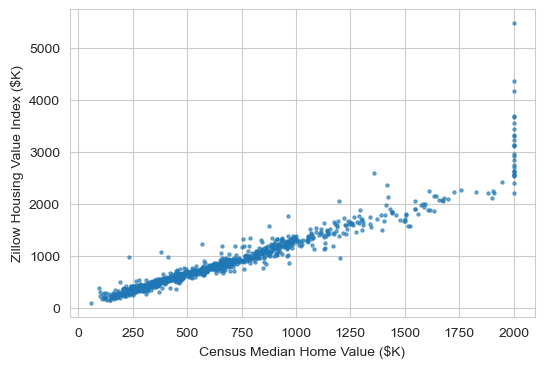

In [23]:
plt.figure(figsize=(6,4))

plt.scatter(df['Median Home Value - Census ($)']/1000, df['Zillow Home Value 2021 ($)']/1000, s=5, alpha=.6)

plt.ylabel('Zillow Housing Value Index ($K)')
plt.xlabel('Census Median Home Value ($K)')


In [ ]:
Zillow works better

Text(0, 0.5, 'Total Units in FAIR Plan Data')

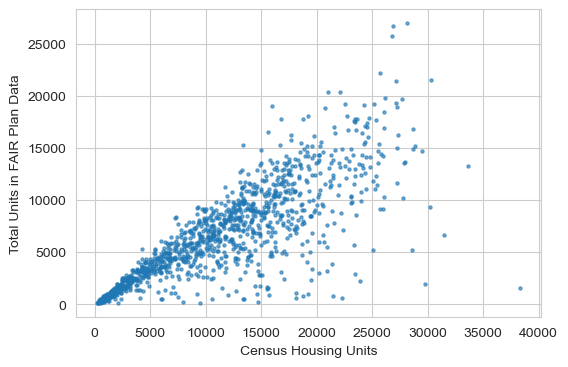

In [31]:
plt.figure(figsize=(6,4))

plt.scatter(df['Housing Units'], df['Total Res Units'], s=5, alpha=.6)

plt.xlabel('Census Housing Units')
plt.ylabel('Total Units in FAIR Plan Data')


In [29]:
np.mean((df['Housing Units'] - df['Total Res Units']) / df['Housing Units'])

np.float64(0.38162605740881855)